# Machine learning with tensorflow2/keras Python modules:

# Training / test of a convolutional neural network for the classification of material micrographs

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal">
     It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: a PVE makes it possible to control for each project the versions of the Python interpreter and “sensitive” modules (like tensorflow for example).

In this notebook, we will illustrate the influence of __Early Stopping__ strategies on the training of the Neural Network.

The details on the loading and the preprocessing of the micrograps images are exposed in the `01_Classify_micrographs.ipynb` notebook.

## Import the required Python modules

In [1]:
# suppress tensorflow verbose warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import sys, random, cv2
import matplotlib.pyplot as plt

# specific modules:
from utils.tools import scan_dir, plot_loss_accuracy

In [3]:
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.8.18
tensorflow: 2.8.2 with keras 2.8.0
numpy     : 1.24.3
OpenCV    : 4.6.0


In [4]:
# allows to visualize the graphs directly in the cell of the N.B.
%matplotlib inline

# SEED will be used to fix the seed of the random generators to get 
# repeatable random numbers series:
SEED = 43

## 1 $-$ Loading all the images

We load the images (resized and converted in gray tone) into a single `ndarray`:

In [5]:
images, labels = [], []

# define data_subdirs: the subdirectories in "../Data":
image_dir = "../Data"
data_subdirs = os.listdir(image_dir)
data_subdirs.sort()

# define label_text as the names of the subdirs:
label_text = data_subdirs

# define label_rank to get labels as numbers:
label_rank = range(len(data_subdirs))

for d, lab  in zip(data_subdirs, label_rank):
    print(f'\nLabel:{lab}, material:[{d}]')
    
    files = os.listdir(os.path.join('../Data', d))
    files.sort()
    
    for f in files:
        print(f'\r\treading file {f}', end='')
        
        image_path = os.path.join('../Data', d, f)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
        img = cv2.resize(img, dsize=(800, 600))    # new size given as: (width, height)
        
        images.append(img)
        labels.append(lab)

    print(f'\rdone{40*" "}')
    
# convert lists as ndarrays:    
images = np.array(images)
labels = np.array(labels)


Label:0, material:[0-Hypoeutectoid steel]
done                                        

Label:1, material:[1-Hypoeutectic white cast iron]
done                                        

Label:2, material:[2-Hypereutectoid Steel]
done                                        


In [6]:
label_text, list(label_rank)

(['0-Hypoeutectoid steel',
  '1-Hypoeutectic white cast iron',
  '2-Hypereutectoid Steel'],
 [0, 1, 2])

Summary:

In [7]:
print(f"'images' ndarray -> shape: {images.shape}, dtype: {images.dtype}")
print(f"'labels' ndarray -> shape: {labels.shape}, dtype: {labels.dtype}")
print(f"total size of 'images' ndarray in memory: {images.size/1024/1024:.1f} MB")

'images' ndarray -> shape: (320, 600, 800), dtype: uint8
'labels' ndarray -> shape: (320,), dtype: int64
total size of 'images' ndarray in memory: 146.5 MB


## 2 $-$ Prepare the _train_ data set and the _test_ data set:

Thanks to the `train_test_split` function of the `sklearn` module we can split the `images` and `labels` ndarrays into a `train` dataset (for the training) and a `test` dataset (for testing).<br>
Images and labels are randomly selected but respecting the proportion of each of the 3 classes in the original dataset (this is the interest of the `stratify` argument of the `train_test_split` function):

In [8]:
from sklearn.model_selection import train_test_split

im_train, im_test, lab_train, lab_test = train_test_split(images, labels,
                                                          stratify=labels,  # use labels to evenly distribute all 
                                                                            # classes in the train and test dadasets
                                                          test_size=0.15,   # 15 % test, 85% train 
                                                          random_state=SEED, 
                                                          shuffle=True)     # shuffe randomly the data

### Data set parameters:

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered from the data set:
- with the shape attribute of the `im_train` and `im_test` arrays
- with the size attribute of the first training image for example


In [9]:
# number of training images:
nb_im_train = im_train.shape[0]

# number of test images:
nb_im_test  = im_test.shape[0]     

# number of elements (pixels) of the firts training image: 
nb_pixel    = im_train[0].size   

# Visual checking:
print(f"{nb_im_train} training images and {nb_im_test} test images")
print(f"{im_train.shape[1]}x{im_train.shape[2]}={nb_pixel} pixels in each image")

# number of classes:
nb_classe = len(set(labels))
print(f"{nb_classe} different classes found in the `labels` ndarray")

272 training images and 48 test images
600x800=480000 pixels in each image
3 different classes found in the `labels` ndarray


### Updating the dimensions of the input data for the _keras_ module:

The convolutional layers of the *kera*s module expect 4-dimensional arrays `(batch_size, height, width, depth)` by default:
- `batch_size`: number of input images,
- `height` and `width`: height and width of images (in pixels),
- `depth`: depth of the arrays (`3` for an RGB image, `1` for a grayscale image).

The form of our images is:

In [10]:
im_train.shape, im_test.shape

((272, 600, 800), (48, 600, 800))

It is therefore necessary to add a dimension (equal to `1`) after the third dimension `800`, for example with the `reshape` method of the `ndarray` arrays of numpy, without forgetting to divide the arrays by 255 to __normalize__ them entries:

In [11]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

Check:

In [12]:
im_train.shape, x_train.shape, x_train.min(), x_train.max(),

((272, 600, 800), (272, 600, 800, 1), 0.0, 1.0)

In [13]:
im_test.shape, x_test.shape, x_test.min(), x_test.max()

((48, 600, 800), (48, 600, 800, 1), 0.0, 1.0)

### One-hot formatting of labels

The labels data must be given as an array of vectors one-hot coding the integer value of the labels: we us 

In [14]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of the train and test labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

## 3 $-$ Build the convolutional neural network

We build a convolutional NN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.
LeNet5 was originally designed for 32$\times$32 images:

![img/LeNet5.png](img/LeNet5.png)

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D,  MaxPool2D, Flatten

# fix the seed of the random generators used by tensorflow:
tf.random.set_seed(SEED)

model = Sequential(name='LeNet5')
model.add(Input(shape=x_train[0].shape))
model.add(Conv2D(6, kernel_size=5, padding='same', activation='relu', name='C1'))
model.add(MaxPool2D(pool_size=2, name='S2'))
model.add(Conv2D(16, kernel_size=5, padding='valid', activation='relu', name='C3'))
model.add(MaxPool2D(pool_size=2, name='S4'))
model.add(Conv2D(120, kernel_size=5, padding='valid', activation='relu', name='C5'))
model.add(Flatten())
model.add(Dense(84, activation='relu', name='F6'))
model.add(Dense(nb_classe, activation='softmax', name='Output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 600, 800, 6)       156       
                                                                 
 S2 (MaxPooling2D)           (None, 300, 400, 6)       0         
                                                                 
 C3 (Conv2D)                 (None, 296, 396, 16)      2416      
                                                                 
 S4 (MaxPooling2D)           (None, 148, 198, 16)      0         
                                                                 
 C5 (Conv2D)                 (None, 144, 194, 120)     48120     
                                                                 
 flatten (Flatten)           (None, 3352320)           0         
                                                                 
 F6 (Dense)                  (None, 84)                28159

### Save the initial state of the network (structure & data)

You can save the the initial weights of the untrained network (random values) and its structure with the `model.save` method. <br>
This will be useful later to recreate the network to its initial state before running any training:

In [17]:
import os

# Check wether the 'model' exist and create it if not:
if not os.path.exists("models"): os.mkdir("models")

# save the structure and the initial waights of the network:
key = 'lenet5_init'
model.save('models/'+key)

# display the tree beginning at f'./models/{key}':
tree = scan_dir(f"./models/{key}")
print(f'\nFiles written:\n{tree}')

INFO:tensorflow:Assets written to: models/lenet5_init/assets

Files written:
./models/lenet5_init/keras_metadata.pb
./models/lenet5_init/saved_model.pb
./models/lenet5_init/variables/variables.index
./models/lenet5_init/variables/variables.data-00000-of-00001
./models/lenet5_init/assets/



## 4 $-$ Train the network with _Early stopping_ on `val_accuracy`

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    EarlyStopping(monitor='val_accuracy',  # The parameter to monitor
                  patience=1,              # accept that 'val_accuracy' decrease 1 time
                  restore_best_weights=True,
                  verbose=1)
]

# define the key to reload the initial state & structure of the network:
key = 'lenet5_init'

# define the path used:
model_path = os.path.join('models', key)

# load the network structure and initial weights:
model = tf.keras.models.load_model(model_path)

# Deterministic tensorflow training: 
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism() 

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=25,     # the total number of successive trainings
                 batch_size=10, # fragmentation of the whole dada set in batches
                 callbacks = callbacks_list)

Epoch 1/25
28/28 [==============================] - 40s 1s/step - loss: 6.6586 - accuracy: 0.3713 - val_loss: 1.0789 - val_accuracy: 0.3333
Epoch 2/25
28/28 [==============================] - 38s 1s/step - loss: 0.7346 - accuracy: 0.6875 - val_loss: 1.0496 - val_accuracy: 0.3542
Epoch 3/25
28/28 [==============================] - 39s 1s/step - loss: 0.2319 - accuracy: 0.8860 - val_loss: 0.1310 - val_accuracy: 1.0000
Epoch 4/25
28/28 [==============================] - 38s 1s/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4: early stopping


### Display the `accuracy` and `loss` curves:

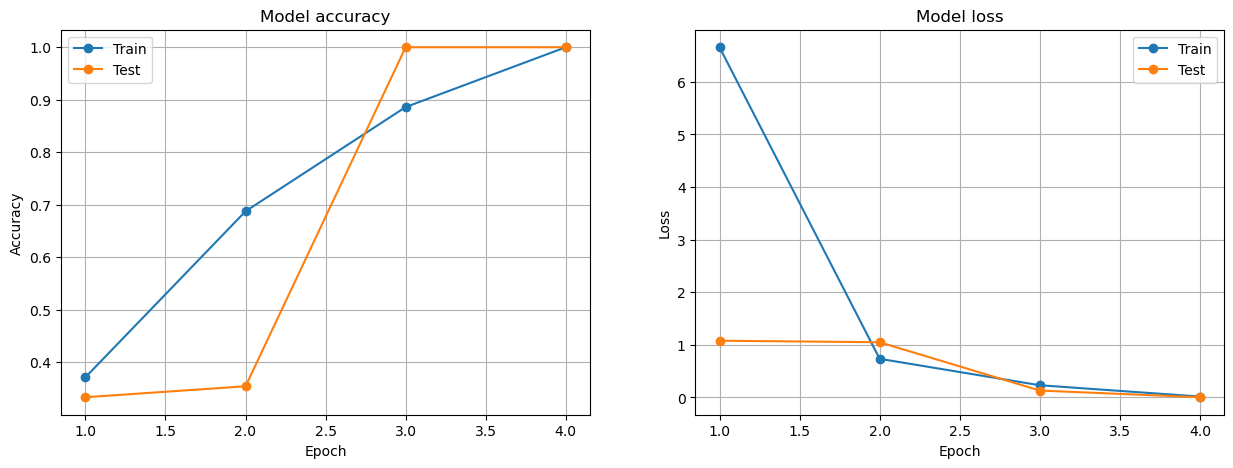

In [19]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Show the confusion matrix

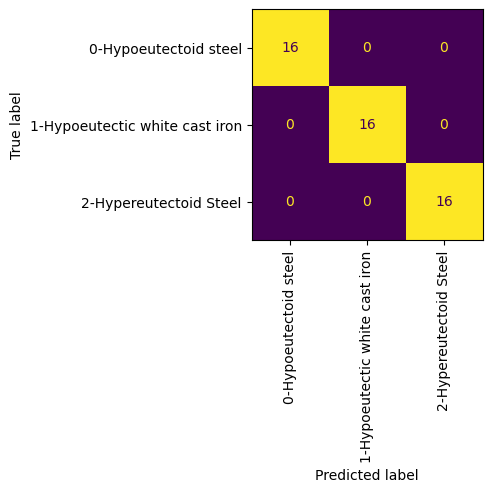

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(3,3))
axis = plt.axes()

raw_results = model.predict(x_test)          # restults is an array of probabilities vectors
inferences  = raw_results.argmax(axis=-1)     # extract the highest probablities

ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=label_text, 
                                        xticks_rotation='vertical',
                                        colorbar=False);

### Look at the classification score for some test images:

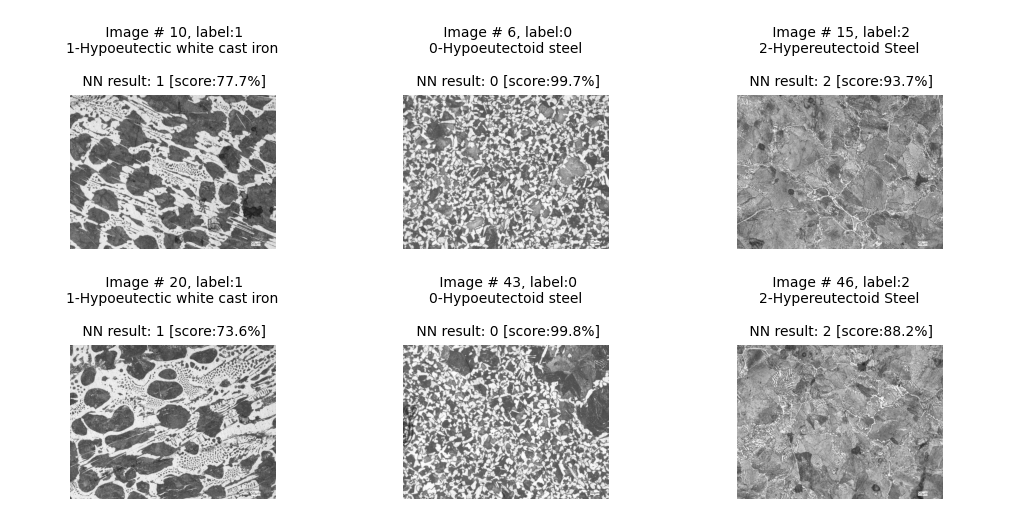

In [21]:
fig, axes = plt.subplots(2, 3, layout="constrained")
fig.set_size_inches((10,5))

for axis, n in zip(axes.flatten(), (10, 6, 15, 20, 43, 46)):
    results = model.predict(x_test[n:n+1])
    answer = results.argmax()

    axis.imshow(x_test[n], cmap='gray')
    title = f'\n Image # {n}, label:{lab_test[n]}\n{label_text[lab_test[n]]}'
    title += f'\n\n NN result: {answer} [score:{results[0, answer]*100:.1f}%]'
    axis.set_title(title, fontsize=10)
    axis.axis('off')
    axis.axis('equal')  

## 5 $-$ Train the network with _Early stopping_ on `val_loss`

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    EarlyStopping(monitor='val_loss',  # The parameter to monitor
                  patience=1,          # accept that 'val_loss' increase 2 times
                  restore_best_weights=True,
                  verbose=1)
]

# define the key to reload the initial state & structure of the network:
key = 'lenet5_init'

# define the path used:
model_path = os.path.join('models', key)

# load the network structure and initial weights:
model = tf.keras.models.load_model(model_path)

# Deterministic tensorflow training: 
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism() 

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=25,     # the total number of successive trainings
                 batch_size=10, # fragmentation of the whole dada set in batches
                 callbacks = callbacks_list)

Epoch 1/25
28/28 [==============================] - 38s 1s/step - loss: 6.6586 - accuracy: 0.3713 - val_loss: 1.0789 - val_accuracy: 0.3333
Epoch 2/25
28/28 [==============================] - 38s 1s/step - loss: 0.7346 - accuracy: 0.6875 - val_loss: 1.0496 - val_accuracy: 0.3542
Epoch 3/25
28/28 [==============================] - 40s 1s/step - loss: 0.2319 - accuracy: 0.8860 - val_loss: 0.1310 - val_accuracy: 1.0000
Epoch 4/25
28/28 [==============================] - 37s 1s/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/25
28/28 [==============================] - 39s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/25
28/28 [==============================] - 39s 1s/step - loss: 2.1942e-04 - accuracy: 1.0000 - val_loss: 8.6455e-04 - val_accuracy: 1.0000
Epoch 7/25
28/28 [==============================] - 41s 1s/step - loss: 8.5219e-05 - accuracy: 1.0000 - val_loss: 6.4277e-04 - val_accuracy: 1.0000
Epoc

### Display the `accuracy` and `loss` curves:

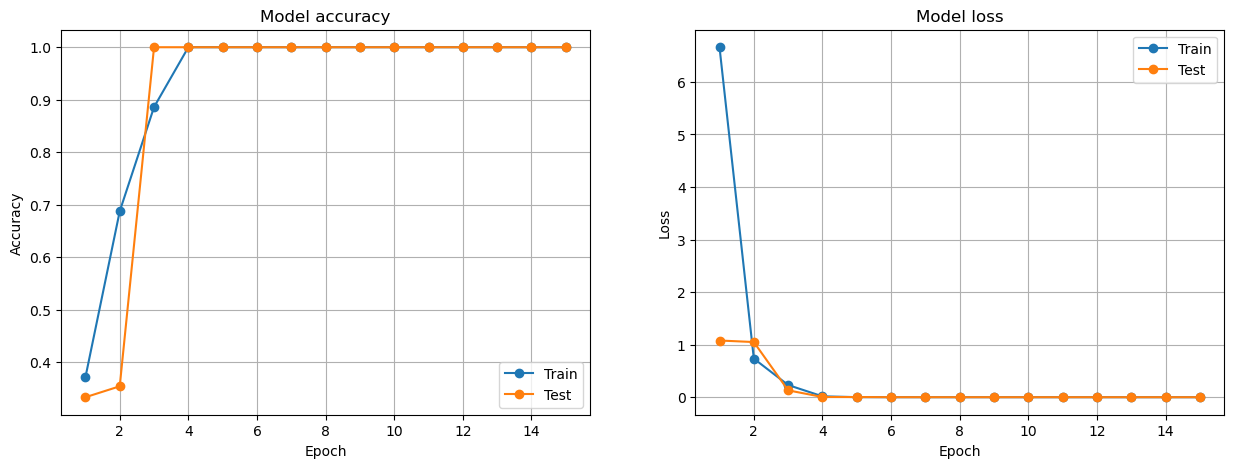

In [23]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Show the confusion matrix

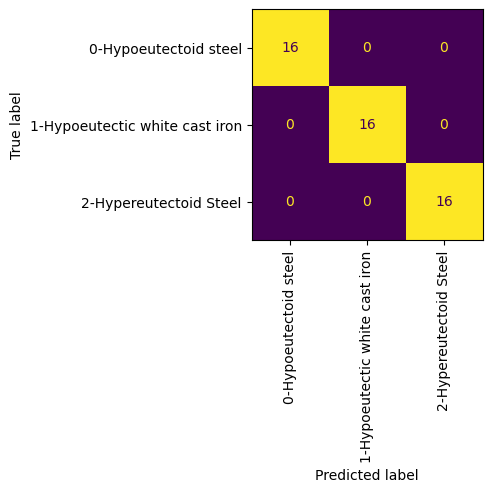

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(3,3))
axis = plt.axes()

raw_results = model.predict(x_test)          # restults is an array of probabilities vectors
inferences  = raw_results.argmax(axis=-1)     # extract the highest probablities

ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=label_text, 
                                        xticks_rotation='vertical',
                                        colorbar=False);

### Look at the classification score for some images:

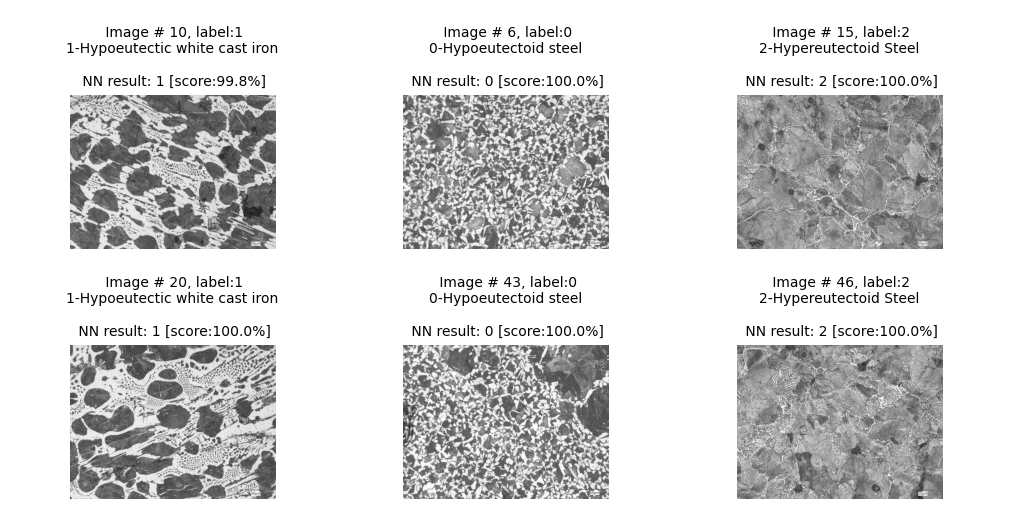

In [25]:
fig, axes = plt.subplots(2, 3, layout="constrained")
fig.set_size_inches((10,5))

for axis, n in zip(axes.flatten(), (10, 6, 15, 20, 43, 46)):
    results = model.predict(x_test[n:n+1])
    answer = results.argmax()

    axis.imshow(x_test[n], cmap='gray')
    title = f'\n Image # {n}, label:{lab_test[n]}\n{label_text[lab_test[n]]}'
    title += f'\n\n NN result: {answer} [score:{results[0, answer]*100:.1f}%]'
    axis.set_title(title, fontsize=10)
    axis.axis('off')
    axis.axis('equal')  